In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import latent_plot as lp
from torch.autograd import Variable
from torch.optim import lr_scheduler
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from data_loader import *
from model import convVAE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#vae model structure
model = convVAE((3,128,128),2048).cuda()
model.load_state_dict(torch.load('/home/vip/sayan-mandal/vae-savedmodels/bestdfcvae_inp128_nl2048_a1b1.torch'))
print(model)

convVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=4096, bias=True)
    (1): BatchNo

### This section covers mdprob analysis

In [4]:
#only on validation set
csv_path = '/home/vip/sayan-mandal/datasets/obj_criteria/20200619-objective.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

ResizeParam = 128
FD = PROBDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(ResizeParam), transforms.RandomHorizontalFlip(p=0.5) ,transforms.ToTensor()]))
FD2 = PROBDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(ResizeParam), transforms.ToTensor()]))

#random sampler
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(FD)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
val_indices =  indices[:split]

# Creating PT data samplers and loaders:
valid_sampler = SubsetRandomSampler(val_indices)

#train_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=train_sampler)
data_loader = torch.utils.data.DataLoader(FD2, batch_size=batch_size, sampler=valid_sampler)

In [5]:
for i, (data,label) in enumerate(data_loader):
    y, _,_ =  model.encode(Variable(data).cuda())
    y = y.cpu().detach().numpy()
    if i == 0:
        yd = y
        lbl = label.numpy()
    else:
        yd = np.append(yd,y,axis=0)
        lbl = np.append(lbl,label.numpy(), axis=0)

In [6]:
n_comp = 2
perplexity = 30
y_embed = TSNE(n_components=n_comp, perplexity=perplexity).fit_transform(yd)
#labels = ['normal','glaucoma']

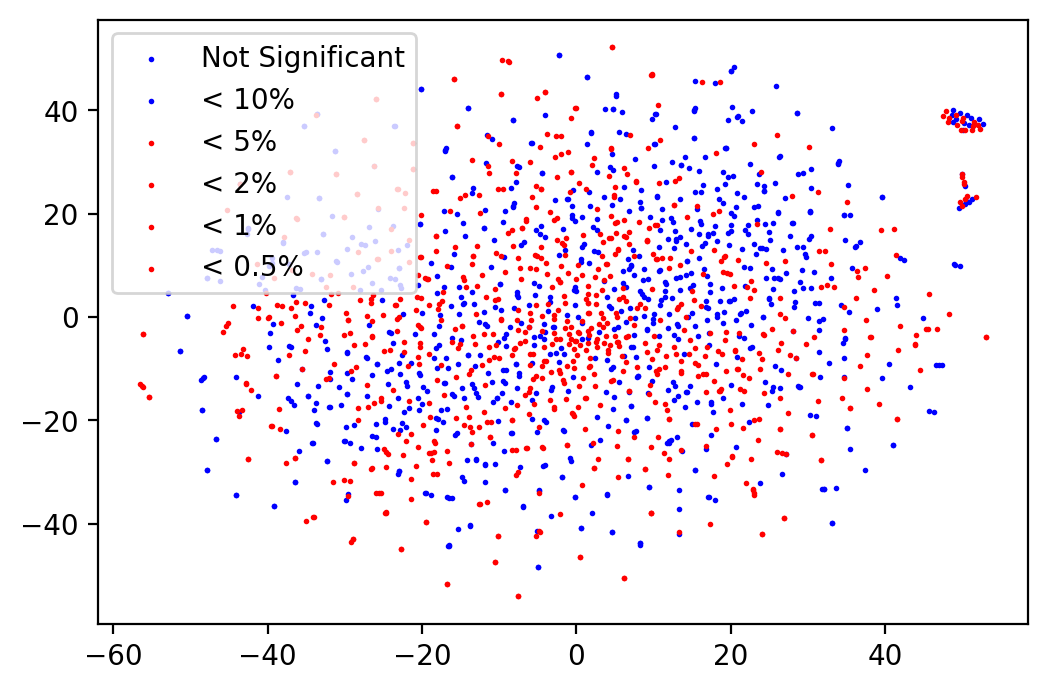

In [7]:
classes = ['Not Significant','< 10%','< 5%','< 2%' ,'< 1%' ,'< 0.5%']
fig, ax = plt.subplots()
#cdict = {0: 'blue', 1: 'green', 2: 'yellow',3:'purple',4:'orange' ,5:'red'}
cdict = {0: 'blue', 1: 'blue', 2: 'red',3:'red',4:'red' ,5:'red'}
for g in np.unique(lbl):
    #print(g)
    idx = np.where(lbl == g)
    ax.scatter(y_embed[idx,0],y_embed[idx,1],c=cdict[g], label = classes[g], s = 1, alpha = 1)
ax.legend()
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

lbl_toCV = lbl.copy()
lbl_toCV[lbl == 0] = 0
lbl_toCV[lbl == 1] = 0
lbl_toCV[lbl == 2] = 1
lbl_toCV[lbl == 3] = 1
lbl_toCV[lbl == 4] = 1
lbl_toCV[lbl == 5] = 1

In [9]:
rfc = RandomForestClassifier()
cv_results = cross_validate(rfc, yd, lbl_toCV, cv = 5, scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc'])
cv_results

{'fit_time': array([2.44795918, 2.42173338, 2.42746449, 2.48387241, 2.43587303]),
 'score_time': array([0.02339458, 0.02315021, 0.02319074, 0.0233345 , 0.02298808]),
 'test_accuracy': array([0.72753623, 0.77681159, 0.76521739, 0.72463768, 0.71304348]),
 'test_f1': array([0.70440252, 0.75709779, 0.73089701, 0.70588235, 0.69158879]),
 'test_precision': array([0.74172185, 0.8       , 0.82089552, 0.73076923, 0.7254902 ]),
 'test_recall': array([0.67065868, 0.71856287, 0.65868263, 0.68263473, 0.66071429]),
 'test_roc_auc': array([0.79203391, 0.85287291, 0.82999731, 0.7866346 , 0.78304076])}

### This section covers psdprob analysis

In [11]:
FD = PROBDataLoader(csv_path, img_path, labeltype = 'psdprob' ,transform=transforms.Compose([transforms.Resize(ResizeParam), transforms.ToTensor()]))
data_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=valid_sampler)

In [12]:
for i, (data,label) in enumerate(data_loader):
    y, _,_ =  model.encode(Variable(data).cuda())
    y = y.cpu().detach().numpy()
    if i == 0:
        yd = y
        lbl = label.numpy()
    else:
        yd = np.append(yd,y,axis=0)
        lbl = np.append(lbl,label.numpy(), axis=0)

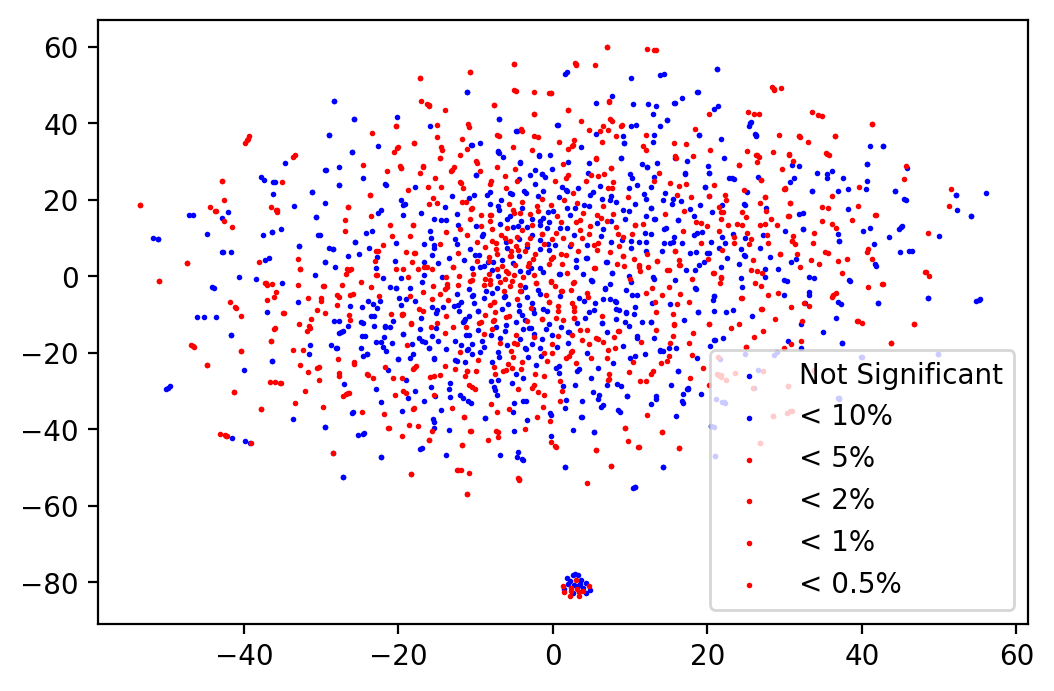

In [13]:
n_comp = 2
perplexity = 30
y_embed = TSNE(n_components=n_comp, perplexity=perplexity).fit_transform(yd)
#labels = ['normal','glaucoma']

classes = ['Not Significant','< 10%','< 5%','< 2%' ,'< 1%' ,'< 0.5%']
fig, ax = plt.subplots()
#cdict = {0: 'blue', 1: 'green', 2: 'yellow',3:'purple',4:'orange' ,5:'red'}
cdict = {0: 'blue', 1: 'blue', 2: 'red',3:'red',4:'red' ,5:'red'}
for g in np.unique(lbl):
    #print(g)
    idx = np.where(lbl == g)
    ax.scatter(y_embed[idx,0],y_embed[idx,1],c=cdict[g], label = classes[g], s = 1, alpha = 1)
ax.legend()
plt.show()

In [14]:
lbl_toCV = lbl.copy()
lbl_toCV[lbl == 0] = 0
lbl_toCV[lbl == 1] = 0
lbl_toCV[lbl == 2] = 1
lbl_toCV[lbl == 3] = 1
lbl_toCV[lbl == 4] = 1
lbl_toCV[lbl == 5] = 1

rfc = RandomForestClassifier()
cv_results = cross_validate(rfc, yd, lbl_toCV, cv = 5, scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc'])
cv_results

{'fit_time': array([2.41646481, 2.42922878, 2.434376  , 2.40717745, 2.46025896]),
 'score_time': array([0.02330852, 0.0230515 , 0.02314234, 0.02342415, 0.02315521]),
 'test_accuracy': array([0.77391304, 0.72173913, 0.69565217, 0.77391304, 0.77971014]),
 'test_f1': array([0.77192982, 0.72881356, 0.69565217, 0.77325581, 0.78285714]),
 'test_precision': array([0.78106509, 0.71666667, 0.70175439, 0.78235294, 0.77840909]),
 'test_recall': array([0.76300578, 0.74137931, 0.68965517, 0.76436782, 0.78735632]),
 'test_roc_auc': array([0.86755612, 0.79784231, 0.78628084, 0.8207972 , 0.8482725 ])}

### This section covers MD analysis

In [15]:
FD = MDDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(ResizeParam), transforms.ToTensor()]))
data_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=valid_sampler)

In [16]:
for i, (data,label,label1) in enumerate(data_loader):
    y, _,_ =  model.encode(Variable(data).cuda())
    y = y.cpu().detach().numpy()
    if i == 0:
        yd = y
        lbl = label.numpy()
        lbl1 = label1.numpy()
    else:
        yd = np.append(yd,y,axis=0)
        lbl = np.append(lbl,label.numpy(), axis=0)
        lbl1 = np.append(lbl1,label1.numpy(), axis=0)

In [17]:
y_embed = TSNE(n_components=n_comp, perplexity=perplexity).fit_transform(yd)

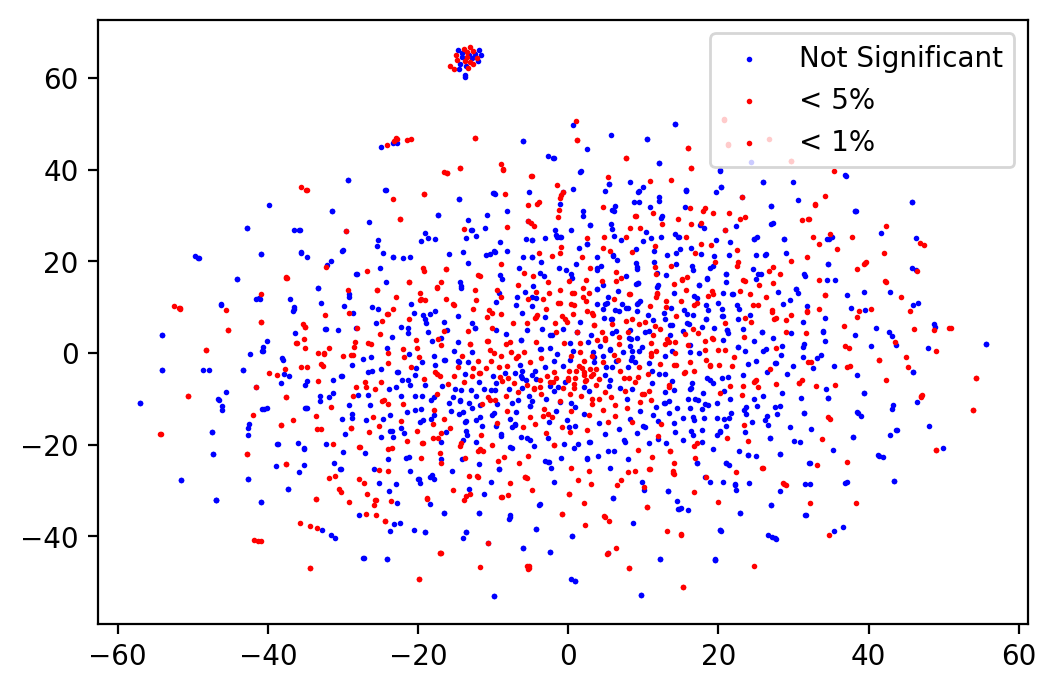

In [18]:
classes = ['Not Significant','< 10%','< 5%','< 2%' ,'< 1%' ,'< 0.5%']
fig, ax = plt.subplots()
#cdict = {0: 'blue', 1: 'green', 2: 'yellow',3:'purple',4:'orange' ,5:'red'}
cdict = {0: 'blue', 1: 'blue', 2: 'red',3:'red',4:'red' ,5:'red'}
for g in np.unique(lbl):
    #print(g)
    idx = np.where(lbl == g)
    ax.scatter(y_embed[idx,0],y_embed[idx,1],c=cdict[g], label = classes[g], s = 1, alpha = 1)
ax.legend()
plt.show()

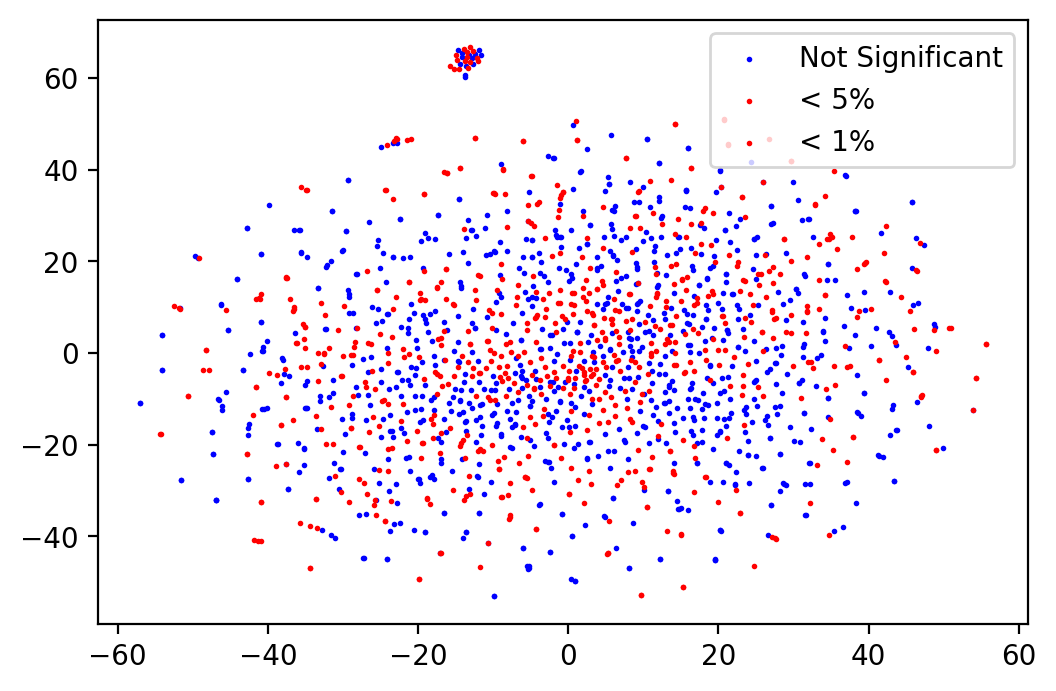

In [19]:
classes = ['Not Significant','< 10%','< 5%','< 2%' ,'< 1%' ,'< 0.5%']
fig, ax = plt.subplots()
#cdict = {0: 'blue', 1: 'green', 2: 'yellow',3:'purple',4:'orange' ,5:'red'}
cdict = {0: 'blue', 1: 'blue', 2: 'red',3:'red',4:'red' ,5:'red'}
for g in np.unique(lbl1):
    #print(g)
    idx = np.where(lbl1 == g)
    ax.scatter(y_embed[idx,0],y_embed[idx,1],c=cdict[g], label = classes[g], s = 1, alpha = 1)
ax.legend()
plt.show()

In [20]:
lbl_toCV = lbl.copy()
lbl_toCV[lbl == 0] = 0
lbl_toCV[lbl == 1] = 0
lbl_toCV[lbl == 2] = 1
lbl_toCV[lbl == 3] = 1
lbl_toCV[lbl == 4] = 1
lbl_toCV[lbl == 5] = 1

rfc = RandomForestClassifier()
cv_results = cross_validate(rfc, yd, lbl_toCV, cv = 5, scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc'])
cv_results

{'fit_time': array([2.52532458, 2.50658512, 2.54999685, 2.55206585, 2.52327943]),
 'score_time': array([0.02299809, 0.02303219, 0.02305913, 0.02330852, 0.02298856]),
 'test_accuracy': array([0.70434783, 0.69565217, 0.74782609, 0.70724638, 0.70144928]),
 'test_f1': array([0.575     , 0.54935622, 0.6741573 , 0.60079051, 0.59922179]),
 'test_precision': array([0.76666667, 0.77108434, 0.76923077, 0.73076923, 0.71296296]),
 'test_recall': array([0.46      , 0.42666667, 0.6       , 0.51006711, 0.51677852]),
 'test_roc_auc': array([0.80121368, 0.78499145, 0.81470085, 0.77497945, 0.76908985])}

In [21]:
lbl_toCV = lbl1.copy()
lbl_toCV[lbl1 == 0] = 0
lbl_toCV[lbl1 == 1] = 0
lbl_toCV[lbl1 == 2] = 1
lbl_toCV[lbl1 == 3] = 1
lbl_toCV[lbl1 == 4] = 1
lbl_toCV[lbl1 == 5] = 1

rfc = RandomForestClassifier()
cv_results = cross_validate(rfc, yd, lbl_toCV, cv = 5, scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc'])
cv_results

{'fit_time': array([2.52332306, 2.53182817, 2.64222527, 2.66780448, 2.53464007]),
 'score_time': array([0.02374244, 0.02323604, 0.02633476, 0.02368927, 0.02287126]),
 'test_accuracy': array([0.71594203, 0.71014493, 0.73623188, 0.71304348, 0.72753623]),
 'test_f1': array([0.59166667, 0.609375  , 0.651341  , 0.60869565, 0.624     ]),
 'test_precision': array([0.77173913, 0.72897196, 0.75892857, 0.74038462, 0.77227723]),
 'test_recall': array([0.47972973, 0.52348993, 0.5704698 , 0.51677852, 0.52348993]),
 'test_roc_auc': array([0.81228564, 0.79547322, 0.81644638, 0.80429051, 0.80863923])}